# Word2Vec implementation with softmax probability
## by Nigel Wright

In [26]:
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

### Text is a children's story I read to my daughter. I wanted something manageable to begin.


In [2]:
book_text = """
The night Max wore his wolf suit and made mischief of one kind
and another
his mother called him “WILD THING!”
and Max said “I’LL EAT YOU UP!”
so he was sent to bed without eating anything.
That very night in Max’s room a forest grew
and grew
and grew until his ceiling hung with vines
and the walls became the world all around
and an ocean tumbled by with a private boat for Max
and he sailed off through night and day
and in and out of weeks
and almost over a year
to where the wild things are.
And when he came to the place where the wild things are
they roared their terrible roars and gnashed their terrible teeth
and rolled their terrible eyes and showed their terrible claws
till Max said “BE STILL!”
and tamed with the magic trick
of staring into all their yellow eyes without blinking once
and they were frightened and called him the most wild thing of all
and made him king of all wild things.
“And now,” cried Max, “let the wild rumpus start!”
“Now stop!” Max said and sent the wild things off to bed without their supper.
And Max the king of all wild things was lonely and wanted to be where
someone loved him best of all.
Then all around from far away across the world
he smelled good things to eat
so he gave up being king of where the wild things are.
But the wild things cried, “Oh please don’t go-
we’ll eat you up we love you so!”
And Max said, “No!”
The wild things roared their terrible roars and gnashed their terrible teeth
and rolled their terrible eyes and showed their terrible claws
but Max stepped into his private boat and waved good-bye
and sailed back over a year
and in and out of weeks
and through a day
and into the night of his very own room
where he found his supper waiting for him
and it was still hot.
"""

### First remove all punctuation, convert text to lowercase, then a list

In [3]:
def preprocess(text):

    for char in string.punctuation:
        text = text.replace(char, ' ')

    words = text.lower().split()
    return words

In [4]:
preprocess("up-we love, you so!")

['up', 'we', 'love', 'you', 'so']

In [5]:
word_tokens = preprocess(book_text)
vocab = list(set(word_tokens))

### Make dictionary to look up index by word

In [6]:
word2idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(vocab)

In [7]:
window_size = 2
pairs = []
for i in range(len(word_tokens)):
    for j in range(i - window_size, i + window_size + 1):
        if j != i and 0 <= j < len(word_tokens):
            pairs.append((word_tokens[i], word_tokens[j]))

pair_idxs = [(word2idx[center_word], word2idx[context_word]) for center_word, context_word in pairs]

### Verify

In [17]:
print(pairs[50])
print(pair_idxs[50])
print(vocab[pair_idxs[50][0]], vocab[pair_idxs[50][1]])

('and', 'kind')
(69, 82)
and kind


### Initialize U and V matrices with random numbers between 0 and 1. Uniform distribution.

In [18]:
d = 50 # d is dimension
U = np.random.random((vocab_size, d))
V = np.random.random((vocab_size, d))
learning_rate = 0.1
epochs = 30
losses = []

## Training Loop. 
## In each epoch, for each pair of words...
### Given every center word w_c, look up scores by multiplying V * w_c
### Compute the probabilities for all context words given w_c
### Calculate the loss (cross-entropy) for the context word (w_t) and add it to the epoch loss

## To derive gradients...
### Make vector "delta" where all probabilities are 0 except the context word w_t = 1
### grad_V  is the gradient of the loss with respect to all context embeddings V. Same shape as V (vocab_size, d)
### grad_U is the gradient of the loss with respect to center word w_c. Shape (d, )
### It is the weighted sum off all context embeddings adjusted by the predicted probabilities. 

### The weights are updated so that w_c moves closer to the true context word w_t

In [19]:
class Experiment:
    def __init__(self, d, lr, epochs):
        self.d = d
        self.lr = lr
        self.epochs = epochs
        self.losses = []

In [89]:
ds = [10, 20, 30, 50, 100]
learning_rates = [1.0, 0.1, 0.01, 0.001]
epochs = 50
experiments = []

for d in ds:
    for lr in learning_rates:
        experiment = Experiment(d=d, lr=lr, epochs=30)
        U = np.random.random((vocab_size, d))
        V = np.random.random((vocab_size, d))
        print(f"Now training model of size d: {d} with learning rate: {lr}")

        for epoch in range(epochs):
            epoch_loss = 0
            np.random.shuffle(pair_idxs)
            for center_idx, context_idx in pair_idxs:
                # w_c will be a shaped (d, )
                w_c = U[center_idx]
                scores = V @ w_c  # scores will be shaped (vocab_size,)

                # Softmax
                exp_scores = np.exp(scores) # softmax numerator -> vector with e ^ score for each 
                probs = exp_scores / exp_scores.sum() # softmax probabilities

                # Loss
                loss = -np.log(probs[context_idx])
                epoch_loss += loss

                # Gradients
                # delta is "ground truth", true prob for all words is 0 except for actual context word
                delta = np.zeros(vocab_size)
                delta[context_idx] = 1

                grad_V = (probs - delta).reshape(-1, 1) * w_c # turning errors into column vector and multiply by w_c to apply to each dimension
                grad_U = np.sum(probs.reshape(-1, 1) * V, axis=0) - V[context_idx]

                # Update weights
                U[center_idx] -= learning_rate * grad_U
                V -= learning_rate * grad_V

            avg_loss = epoch_loss / len(pair_idxs)
            experiment.losses.append(avg_loss)
            print(f"Epoch {epoch + 1}, Loss: {avg_loss}")
        
        experiments.append(experiment)


Now training model of size d: 10 with learning rate: 1.0
Epoch 1, Loss: 4.644607869905083
Epoch 2, Loss: 4.3951121664122965
Epoch 3, Loss: 4.183876614134516
Epoch 4, Loss: 3.9808424806937146
Epoch 5, Loss: 3.8089898280642047
Epoch 6, Loss: 3.6790415760106883
Epoch 7, Loss: 3.564259514723497
Epoch 8, Loss: 3.482274796497986
Epoch 9, Loss: 3.4132063817440987
Epoch 10, Loss: 3.3721988687777764
Epoch 11, Loss: 3.3323038030220262
Epoch 12, Loss: 3.3039542064037106
Epoch 13, Loss: 3.298616607047798
Epoch 14, Loss: 3.2727603661139746
Epoch 15, Loss: 3.2624056219425293
Epoch 16, Loss: 3.2518790612430886
Epoch 17, Loss: 3.2341817987177057
Epoch 18, Loss: 3.2296267212263485
Epoch 19, Loss: 3.223091990999803
Epoch 20, Loss: 3.21277413378796
Epoch 21, Loss: 3.2134069094750517
Epoch 22, Loss: 3.205845049404849
Epoch 23, Loss: 3.1946190538268775
Epoch 24, Loss: 3.193295532774368
Epoch 25, Loss: 3.186891117541356
Epoch 26, Loss: 3.203151886411071
Epoch 27, Loss: 3.198947882917897
Epoch 28, Loss: 3.20

Epoch 34, Loss: 3.0486569500826657
Epoch 35, Loss: 3.05106233160215
Epoch 36, Loss: 3.040554566108791
Epoch 37, Loss: 3.0512799774194885
Epoch 38, Loss: 3.0477089761928284
Epoch 39, Loss: 3.0397086620881923
Epoch 40, Loss: 3.043230044766295
Epoch 41, Loss: 3.035130008969253
Epoch 42, Loss: 3.0345701604808437
Epoch 43, Loss: 3.033771575048599
Epoch 44, Loss: 3.0398689876818716
Epoch 45, Loss: 3.030642918826773
Epoch 46, Loss: 3.04943754672093
Epoch 47, Loss: 3.038186635276505
Epoch 48, Loss: 3.0422000274559693
Epoch 49, Loss: 3.046880623273269
Epoch 50, Loss: 3.020761060888663
Now training model of size d: 20 with learning rate: 0.1
Epoch 1, Loss: 4.6565269176899085
Epoch 2, Loss: 4.299623071792355
Epoch 3, Loss: 4.005377441442465
Epoch 4, Loss: 3.7694888756950182
Epoch 5, Loss: 3.5790632958419146
Epoch 6, Loss: 3.4404383053578056
Epoch 7, Loss: 3.3223209682527206
Epoch 8, Loss: 3.2522963832299188
Epoch 9, Loss: 3.1966894662771477
Epoch 10, Loss: 3.1664480822309753
Epoch 11, Loss: 3.136

Epoch 16, Loss: 3.085045458743887
Epoch 17, Loss: 3.0661986351577406
Epoch 18, Loss: 3.084984141761791
Epoch 19, Loss: 3.072689383522138
Epoch 20, Loss: 3.0773348711678095
Epoch 21, Loss: 3.0614756093553672
Epoch 22, Loss: 3.0484695632572887
Epoch 23, Loss: 3.0646172546451598
Epoch 24, Loss: 3.0580355121380727
Epoch 25, Loss: 3.0590665648392665
Epoch 26, Loss: 3.053035727914899
Epoch 27, Loss: 3.050620611743474
Epoch 28, Loss: 3.041262703746683
Epoch 29, Loss: 3.0550200044525524
Epoch 30, Loss: 3.047310267117061
Epoch 31, Loss: 3.0433242176689705
Epoch 32, Loss: 3.0461615052788775
Epoch 33, Loss: 3.0430557646606022
Epoch 34, Loss: 3.041880050544501
Epoch 35, Loss: 3.0273755243650684
Epoch 36, Loss: 3.035308844473758
Epoch 37, Loss: 3.01995349975656
Epoch 38, Loss: 3.0333481034401846
Epoch 39, Loss: 3.0256031578700555
Epoch 40, Loss: 3.0282401919643265
Epoch 41, Loss: 3.018830576248764
Epoch 42, Loss: 3.0378689912926795
Epoch 43, Loss: 3.0246185409839277
Epoch 44, Loss: 3.03211651014171

Epoch 1, Loss: 4.866172006122562
Epoch 2, Loss: 4.2465365373203925
Epoch 3, Loss: 3.845141770100218
Epoch 4, Loss: 3.589994619992117
Epoch 5, Loss: 3.4321654573927325
Epoch 6, Loss: 3.3281489371005484
Epoch 7, Loss: 3.264840815329714
Epoch 8, Loss: 3.238871701258813
Epoch 9, Loss: 3.200115471557136
Epoch 10, Loss: 3.189213539767986
Epoch 11, Loss: 3.1792636104777316
Epoch 12, Loss: 3.160958921094862
Epoch 13, Loss: 3.138462236285858
Epoch 14, Loss: 3.141209201297786
Epoch 15, Loss: 3.113811444626595
Epoch 16, Loss: 3.1227267951522184
Epoch 17, Loss: 3.107273371606117
Epoch 18, Loss: 3.1016815963833078
Epoch 19, Loss: 3.1045416988943204
Epoch 20, Loss: 3.0959519119542724
Epoch 21, Loss: 3.0940202914163537
Epoch 22, Loss: 3.0867897134426574
Epoch 23, Loss: 3.08403456681176
Epoch 24, Loss: 3.075818906814346
Epoch 25, Loss: 3.068439568005083
Epoch 26, Loss: 3.0692938369256866
Epoch 27, Loss: 3.0638530335517036
Epoch 28, Loss: 3.0602551994961646
Epoch 29, Loss: 3.054677368981154
Epoch 30, L

Epoch 33, Loss: 3.0696824641239377
Epoch 34, Loss: 3.073302757646229
Epoch 35, Loss: 3.0793713748290568
Epoch 36, Loss: 3.0777190450187
Epoch 37, Loss: 3.0663314335999368
Epoch 38, Loss: 3.075992607444834
Epoch 39, Loss: 3.0691421116086177
Epoch 40, Loss: 3.0560717007055205
Epoch 41, Loss: 3.0639354248593156
Epoch 42, Loss: 3.0561594933777023
Epoch 43, Loss: 3.0577699781782752
Epoch 44, Loss: 3.056304562358035
Epoch 45, Loss: 3.0321604961901807
Epoch 46, Loss: 3.0440247753566334
Epoch 47, Loss: 3.0369703466279403
Epoch 48, Loss: 3.044979579040517
Epoch 49, Loss: 3.0378690552456185
Epoch 50, Loss: 3.0254677764793576
Now training model of size d: 100 with learning rate: 0.001
Epoch 1, Loss: 5.297491620342986
Epoch 2, Loss: 4.35353502383539
Epoch 3, Loss: 3.925397588289153
Epoch 4, Loss: 3.7489854949364316
Epoch 5, Loss: 3.6202112404028943
Epoch 6, Loss: 3.5583524272558615
Epoch 7, Loss: 3.525506035292217
Epoch 8, Loss: 3.474660057857024
Epoch 9, Loss: 3.4417686482164322
Epoch 10, Loss: 3

In [90]:
def plot_experiments(experiments, figsize=(12, 8), save_path=None, zoom=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if zoom:
        ax.set_ylim(3, 3.3)
    
    dimensions = sorted(list(set([exp.d for exp in experiments])))
    learning_rates = sorted(list(set([exp.lr for exp in experiments])))
    
    dim_cmap = cm.get_cmap('viridis', len(dimensions))
    lr_styles = ['-', '--', ':', '-.']
    
    for i, exp in enumerate(experiments):
        dim_idx = dimensions.index(exp.d)
        lr_idx = learning_rates.index(exp.lr)
        
        color = dim_cmap(dim_idx)
        linestyle = lr_styles[lr_idx % len(lr_styles)]
        
        epochs = range(1, len(exp.losses) + 1)
        ax.plot(epochs, exp.losses, 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                alpha=0.8,
                label=f'd={exp.d}, lr={exp.lr}')
    
    dim_handles = [Line2D([0], [0], color=dim_cmap(i), linewidth=3) 
                  for i in range(len(dimensions))]
    dim_labels = [f'd = {d}' for d in dimensions]
    
    lr_handles = [Line2D([0], [0], color='gray', linestyle=ls, linewidth=2) 
                 for ls in lr_styles[:len(learning_rates)]]
    lr_labels = [f'lr = {lr}' for lr in learning_rates]
    
    first_legend = ax.legend(dim_handles, dim_labels, title="Dimensions", 
                           loc='upper center', bbox_to_anchor=(0.8, 1), 
                           frameon=True, fontsize=10)
    ax.add_artist(first_legend)
    ax.legend(lr_handles, lr_labels, title="Learning Rates", 
             loc='upper center', bbox_to_anchor=(0.8, 0.8), 
             frameon=True, fontsize=10)
    
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Word Embedding Training Across Different Dimensions and Learning Rates', 
                fontsize=14, fontweight='bold', pad=20)
    
    if not zoom:
    
        best_exp = min(experiments, key=lambda x: min(x.losses))
        best_loss = min(best_exp.losses)
        best_epoch = best_exp.losses.index(best_loss) + 1

        ax.annotate(f'Best: d={best_exp.d}, lr={best_exp.lr}\nLoss={best_loss:.4f} at epoch {best_epoch}',
                   xy=(best_epoch, best_loss),
                   xytext=(best_epoch + 2, best_loss * 1.5),
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                   fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    

/tmp/ipykernel_44960/454695931.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dim_cmap = cm.get_cmap('viridis', len(dimensions))


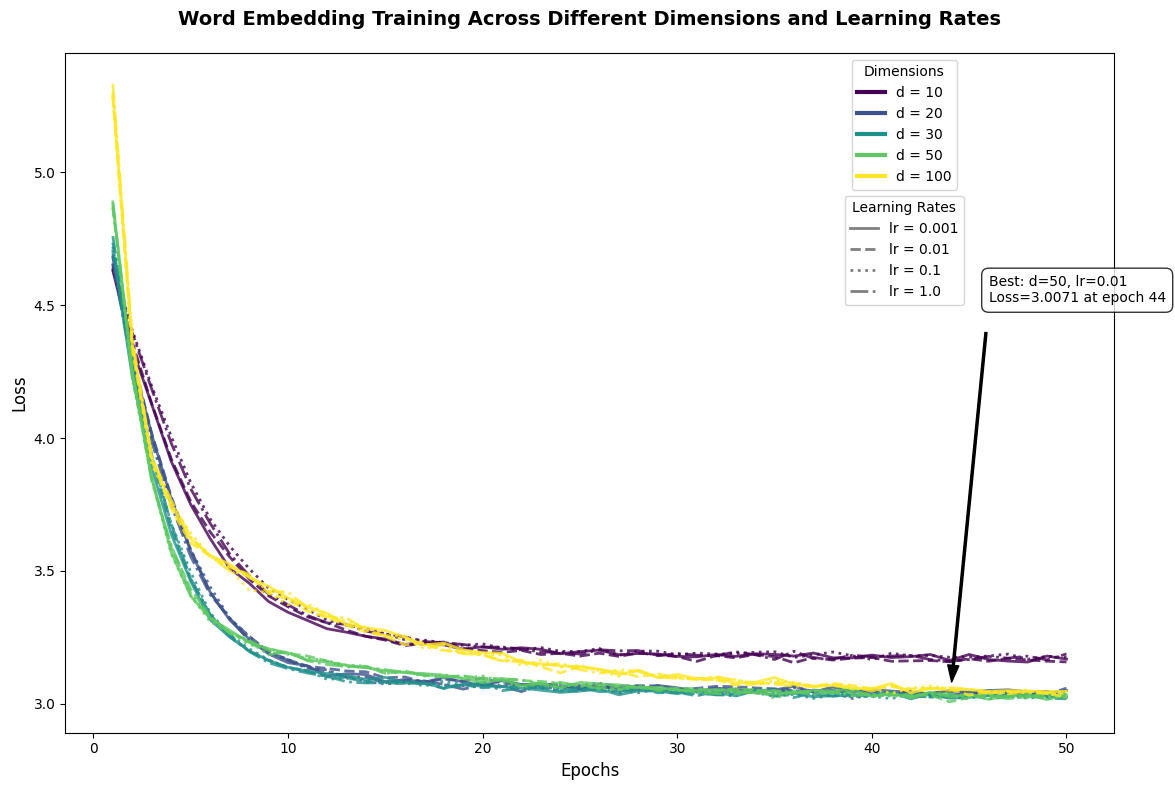

In [91]:
plot_experiments(experiments, save_path="loss_over_epochs_and_params.png")

### Here's a zoomed version to better differentiate.
### If more epochs are run, it looks like the models with 100 dimensions (yellow) may dip below 3. 

/tmp/ipykernel_44960/454695931.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dim_cmap = cm.get_cmap('viridis', len(dimensions))


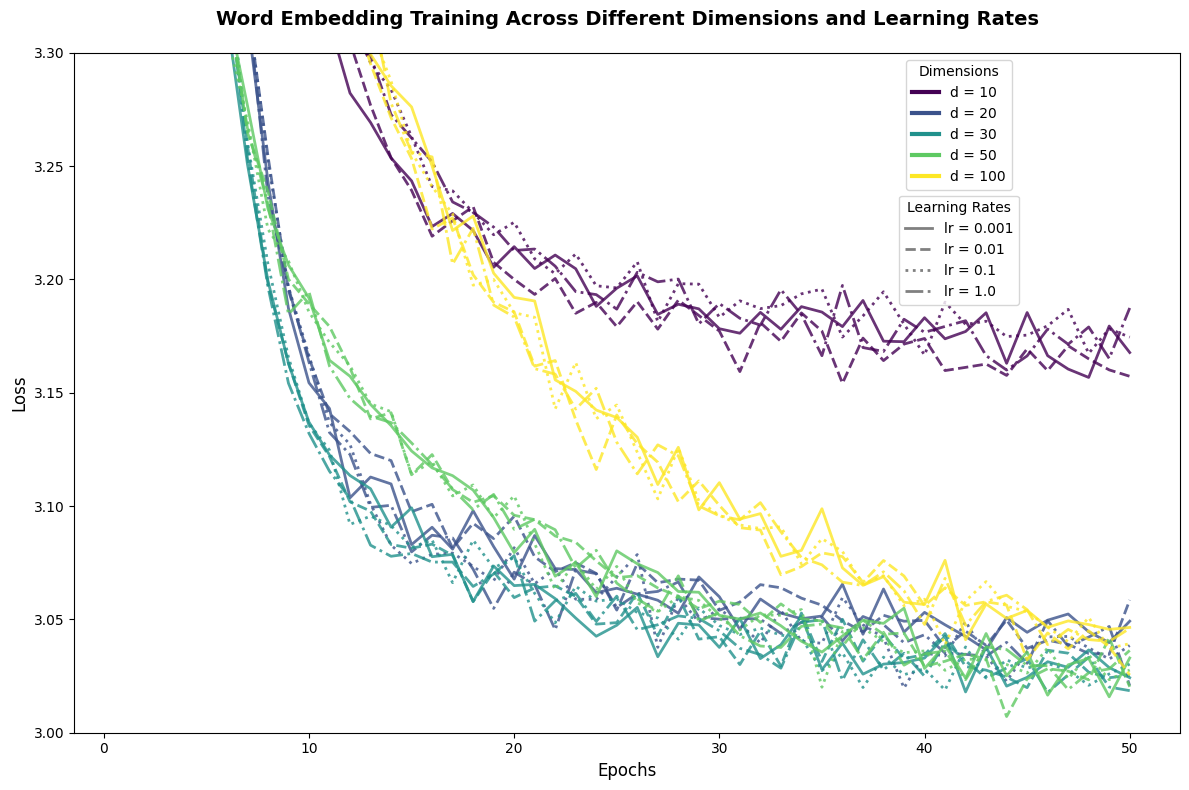

In [99]:
plot_experiments(experiments, zoom=True, save_path="zoomed_training_embeddings.png")

### Similarity between two words is the dot product between them in U

In [93]:
def similarity(word1, word2):
    idx1, idx2 = word2idx[word1], word2idx[word2]
    return U[idx1] @ U[idx2]

In [94]:
print("wild-things:", similarity("wild", "things"))
print("and-the:", similarity("and", "the"))
print("away-terrible:", similarity("away", "terrible"))
print("private-boat:", similarity("private", "boat"))

wild-things: 2.9385157354234486
and-the: 0.3967212842341863
away-terrible: -0.6966470817617216
private-boat: 4.83907633963864


## Heatmap to better visualize word similarity

In [95]:
words_to_compare = ['king', 'night', 'boat', 'wild', 'and', 'he', 'max', 'things', 'said', 'private', 'the', 'terrible']

In [101]:
import seaborn as sns
import pandas as pd

def create_similarity_heatmap(words, similarity_func, figsize=(9, 7), save_path=None):

    similarity_matrix = np.zeros((len(words), len(words)))
    
    # compute similarities
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i != j:
                similarity_matrix[i, j] = similarity_func(word1, word2)
    
    df_similarity = pd.DataFrame(similarity_matrix, 
                                 index=words, 
                                 columns=words)
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(df_similarity, 
                annot=True,
                cmap='coolwarm', 
                center=0,
                square=True,
                mask=np.eye(len(words), dtype=bool),
                cbar_kws={'label': 'Similarity'})
    
    plt.title('Word Embedding Similarity', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return similarity_matrix

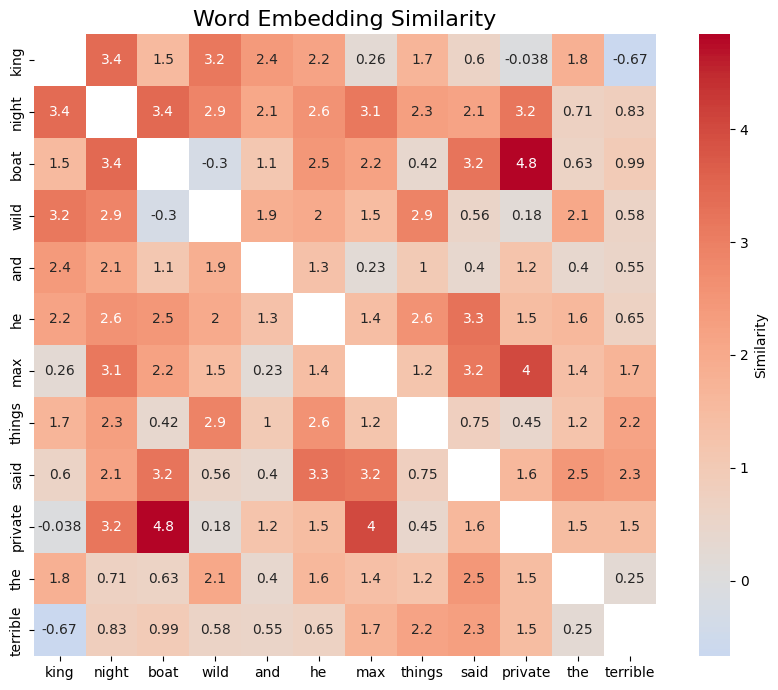

In [102]:
similarity_matrix = create_similarity_heatmap(words_to_compare, similarity, save_path="word_similarity_heatmap.png")

### It makes sense that "private" and "boat" are very similar because they allows occur together in the text. 
### The same with "he" & "said" and "max" & "said", these occur together frequently. 
### I would have thought "he" & "max" would be more similar! 

### **Note!** These similarities are being calculated for the last U & V to be trained, which is d=100 and learning rate = 0.001